# Introdução

Projeto final da cadeira IF807 que tem como o objetivo a implementação de uma técnica dentro do tema de Fairness em sistemas de recomendação. A técnica é baseada em um artigo que pode ser encontrado nesse link: https://dl.acm.org/doi/10.1145/3292500.3330691

Equipe:



O objetivo é implementar um sistema de re-ranqueamento que consideram o Fainess, para que então ocorra menos viéses na hora de gerar listas de ranking em algoritmos de recomendação. Com essa proposta, esse viés é quantificado e mitigado, para um determinado subconjunto de dados, esses algoritmos podem gerar uma distribuição desejada dos resultados mais bem classificados, mantendo assim a paridade demográfica ou a igualdade de oportunidades conforme necessário. 

As métricas são definidas para avaliar o nível de Fairness então alcançado e são mostrador resultados obtidos através de dados sinteticamente gerados que buscam replicar uma aplicação prática de uma busca de talentos do LinkedIn.

# Implementação

### Bibliotecas

In [35]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

### Medidas para avaliação de viés

O artigo lista algumas medidas que podem ser utilizadas para obter o valor de viés de cada um dos algoritmos de recomendação, eles são definidos como o seguinte:

##### Medidas baseada nos top-k resultados

##### Skew@k

O Desvio dos top-k resultados rankeados da proporção desejada é quantificada usando uma métrica skew (assimetria). A função log retorna um valor negativo de assimetria para under representation ou positiva para over representation do atributo que está sendo avaliado. 

In [18]:
def proportion_calc(df,k,ai):
    count=0
    for i in range(k):
        if (df[i] == ai):
            count = count+1
    return (count/k)

def skew_func(df,p,k,ai):
    s = math.log((proportion_calc(df,k,ai)+1)/(p[ai]+1))
    return s

A métrica acima tem alguns problemas, primeiro o fato de que é definida apenas sobre o valor de um atributo e precisa ser estendida para aglobar vários, e também, o valor computado depende altamente do valor k (top valores) e então uma métrica acumulativa e compreensiva é requerida. Para resolver esses problemas, são definidas métricas MinSkew e MaxSkew que quantificam a pior desvantagem e maior vantagem para um candidato.

##### MinSkew@k

In [19]:
def min_skew(df,p,k):
    min_skew_var=float('inf')
    for x in range(len(p)):
        m=skew_func(list(df),p,k,x)
        if m < min_skew_var:
            min_skew_var = m
    return min_skew_var

##### MaxSkew@k

In [20]:
def max_skew(df,p,k):
    max_skew_var=-float('inf')
    for x in range(len(p)):
        m=skew_func(list(df),p,k,x)
        if m > max_skew_var:
            max_skew_var = m
    return max_skew_var

Para o segundo problema citado acima, métricas de ranqueamento são definidas e listadas abaixo.

### Medidas de ranqueamento

##### ndkl_func

A divergência Kullback-Leibler (KL) é uma medida não negativa no qual o valor maior denota uma grande divergência entre as distribuições, ela é implementada como uma medida acumulativa envolvendo uma média baseada em pesos de Skew@i sobre todos os valores de atributo.

Um viés de magnitude igual mas em direções opostas não pode ser distinguido por essa métrica, por isso ele não indica qual atributo está sendo tratado de forma injusta.

In [21]:
def kld_func(D1,D2):
    a = np.asarray(D1, dtype=float)
    b = np.asarray(D2, dtype=float)

    return np.sum(np.where(a != 0 , a * np.log((a +0.00001)/(b+0.00001)), 0))

def ndkl_func(df,p):
    Z = np.sum(1/(np.log2(np.arange(1,len(df)+1)+1)))
    total=0

    for i in range(1,len(df)+1):
        value=df[:i].value_counts(normalize = True)
        value=value.to_dict()
        D1=[]
        for i in range(len(p)):
            if i in value.keys():
                D1.append(value[i])
            else:
                D1.append(0)
        total=total+(1/math.log2(i+1)) * kld_func(D1,p)

    return (1/Z)*total

##### NDCG

Ganho de desconto acumulativo normalizado, o ganho cumulativo captura que os resultados muito relevantes são mais úteis do que os resultados parcialmente relevantes, que, por sua vez, são mais úteis do que os resultados irrelevantes. Dependendo da noção de relevância, que para o caso do teste é o score de cada candidato.

In [22]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0

def ndcg_at_k(df, k, method=0):
    r=list(df)
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

### Propriedades desejadas

Para garantir uma representação justa nos resultados top-k de uma lista classificada, é importante que a proporção de cada atributo protegido (como gênero ou raça) esteja dentro de limites específicos. Se qualquer top-k violar essas proporções mínimas, o sistema é considerado inviável. Duas medidas ajudam a avaliar isso: o Índice Inviável, que conta quantas vezes qualquer top-k quebra a regra de representação mínima, e a Contagem Inviável, que contabiliza todas as violações de representação mínima em cada posição top-k. Essas métricas podem ser ajustadas para diferentes tamanhos de listas e quantidades de atributos para garantir comparações justas.

In [23]:
def infeasible_index(df, p):

    # Parâmetros e variáveis iniciais
    data = df[:100]
    num_attributes = len(p)
    tao_r = 100
    inf_index_tao_r = 0
    inf_count_tao_r = 0

    # Iterar sobre cada top-k
    for k in range(1, tao_r + 1):
        data_temp_k = data[:k]
        infeasible_flag = False

        # Verificar cada valor de atributo protegido
        for i, desired_proportion in enumerate(p):
            observed_count_ai = (data_temp_k['ai'] == i).sum()
            desired_count_ai = math.floor(desired_proportion * k)

            # Atualizar flags e contadores se a condição mínima não for atendida
            if observed_count_ai < desired_count_ai:
                infeasible_flag = True
                inf_count_tao_r += 1

        # Incrementar índice inviável se houver uma violação
        if infeasible_flag:
            inf_index_tao_r += 1

    # Mensagem de erro caso o índice inviável seja maior que 99
    if inf_index_tao_r > 99:
        print(f"Erro em {num_attributes} e é: {inf_index_tao_r}")

    return [inf_index_tao_r, inf_count_tao_r]


### Algoritmos de re-Ranqueamento

##### DetGreedy

O algoritmo DetGreedy funciona assim:

Primeiro, se a representação mínima de um atributo protegido não está sendo cumprida, selecione o item com a maior pontuação disponível.
Caso contrário, selecione o item com a maior pontuação disponível entre os que ainda não atingiram o limite máximo de representação.
Atenção: Embora este algoritmo busque maximizar as pontuações dentro de cada grupo de atributos protegidos, ele pode acabar violando as restrições de representação, tornando a lista final inviável.

In [24]:
def det_greedy(data,p,k_max):
    rankedAttList = []
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        rankedAttList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1

    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])

##### DetCons

O algoritmo DetCons é utilizado para verificar a consistência de um conjunto de restrições binárias em problemas de satisfação de restrições (CSP). Ele revisa cada restrição binária para garantir que nenhum valor possa ser removido de um domínio de variável sem violar a consistência dessa restrição. Este processo é repetido até que nenhum valor possa ser removido sem quebrar a consistência de alguma restrição, assegurando assim a solução consistente do CSP.

In [25]:
def det_cons(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0

    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)

        else:
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]

            nextAtt= min(s,key=s.get)

        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1

    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

#### DetRelaxed

O algoritmo DetRelaxed é utilizado para selecionar um subconjunto de valores de atributos que minimizam uma determinada função ao escolher a próxima pessoa com a pontuação mais alta. Ele trabalha de forma a identificar e listar todos os valores de atributos que atendem a essa condição de minimização. Em outras palavras, o algoritmo procura, entre os possíveis candidatos, aqueles cujos valores de atributos resultam no menor valor possível para uma função específica, garantindo assim a seleção da pessoa mais adequada de acordo com o critério estabelecido.

In [26]:
def det_relax(data, p, k_max):
    ranked_attr_list = []
    ranked_score_list = []
    counts = {}
    for i in range(len(p)):
        counts[i] = 0

    for k in range(1, k_max + 1):
        below_min = {ai for ai, v in counts.items() if v < math.floor(k * p[ai])}
        below_max = {ai for ai, v in counts.items() if v >= math.floor(k * p[ai]) and v < math.ceil(k * p[ai])}
        s = {}
        if len(below_min) != 0:
            for i in below_min:
                s[i] = data[(i, counts[i])]
            next_att = max(s, key=s.get)
        else:
            ns = {}
            for i in below_max:
                ns[i] = math.ceil(math.ceil(i * p[i]) / p[i])
            temp = min(ns.values())
            next_att_set = [key for key in ns if ns[key] == temp]
            for i in next_att_set:
                s[i] = data[(i, counts[i])]
            next_att = max(s, key=s.get)

        ranked_attr_list.append(next_att)
        ranked_score_list.append(data[(next_att, counts[next_att])])
        counts[next_att] += 1

    return pd.DataFrame(list(zip(ranked_attr_list, ranked_score_list)), columns=['ai', 'score'])

#### DetConstSort

O algoritmo DetConstSort ordena candidatos com base em restrições. Primeiro, mantém um contador para o atributo protegido, incrementando-o quando uma classe atinge seu mínimo de representação e organiza as classes em ordem decrescente de pontuação. Depois, insere o próximo candidato no próximo índice vazio da lista de recomendação e ajusta sua posição para a esquerda até que a pontuação dos candidatos anteriores seja maior ou a troca viole a posição máxima permitida para manter a viabilidade.

In [27]:
def swap(dictionary, pos1, pos2):
    dictionary[pos1], dictionary[pos2] = dictionary[pos2], dictionary[pos1]
    return dictionary

def det_const_sort(data, p, k_max):

    ranked_attr_dict = {}
    ranked_score_dict = {}
    max_indices_dict = {}

    counts = {}
    min_counts = {}
    temp_min_counts = {}

    last_empty = 0
    k = 0

    for i in range(len(p)):
        counts[i] = 0
        min_counts[i] = 0

    while last_empty < k_max:
        k += 1
        for j in range(len(p)):
            temp_min_counts[j] = math.floor(k * p[j])

        changed_mins = {ai for ai, s in min_counts.items() if s < temp_min_counts[ai]}
        if len(changed_mins) != 0:
            vals = {}
            for ai in changed_mins:
                vals[ai] = data[(ai, counts[ai])]
            ord_changed_mins = np.asarray(sorted(vals.items(), key=lambda kv: (kv[1], kv[0]), reverse=True))[:, 0].tolist()
            for ai in ord_changed_mins:
                ranked_attr_dict[last_empty] = ai
                ranked_score_dict[last_empty] = data[(ai, counts[ai])]
                max_indices_dict[last_empty] = k
                start = last_empty

                while start > 0 and max_indices_dict[start - 1] >= max_indices_dict[start] and ranked_score_dict[start - 1] < ranked_score_dict[start]:
                    swap(max_indices_dict, start - 1, start)
                    swap(ranked_attr_dict, start - 1, start)
                    swap(ranked_score_dict, start - 1, start)
                    start -= 1
                counts[ai] += 1
                last_empty += 1
            min_counts = temp_min_counts.copy()

    ranked_attr_list = [v for v in ranked_attr_dict.values()]
    ranked_score_list = [v for v in ranked_score_dict.values()]
    return pd.DataFrame(list(zip(ranked_attr_list, ranked_score_list)), columns=['ai', 'score'])


### Executando os algoritmos de Re-Ranking


In [28]:
class experiment:
    """
    This is the simulation framework for generating the data required to run the algorithms.
    It takes in the following variables as user inputs :-
    'max_a' = Maximum cardinality of protected class for which we want to generate synthetic data
    'tasks' = Number of desired probability distributions hypothesized as different queries
    'distribution' = Type of distribution to generate data from. Default-'Uniform'
    'doctrine' = The Doctrine of Fairness to be ensured. Default- 'DI'
    'datapoints' = The number of synthetic Scores to generate for different 'ai' values
    """

    def __init__(self, max_a, tasks, rep, distribution, doctrine):
        self.max_a = max_a
        self.tasks = tasks
        self.rep = rep
        self.distribution = distribution
        self.doctrine = doctrine
        self.datapoints = 100

    def setup(self):
        P = {}
        self.data = {}
        for a in range(2, self.max_a):
            P[f'a={a}'] = self.get_tasks(a)
            for i in P[f'a={a}']:
                for j in range(self.rep):
                    self.data[(f'a={a}', i, j)] = self.gen_data(a)
        return P

    def get_tasks(self, a):
        T = {}
        for i in range(self.tasks):
            T[i] = self.get_distribution(a)
        return T

    def get_distribution(self, a):
        d = []
        for _ in range(a):
            d.append(np.random.uniform())
        d_norm = [float(i)/sum(d) for i in d]
        return d_norm

    def gen_data(self, a):
        scores = {}
        scoresgen = []
        for i in range(a):
            for j in range(self.datapoints):
                scoresgen.append(np.random.uniform())
            scoresgen.sort(reverse=True)
            for j in range(self.datapoints):
                scores[(i, j)] = scoresgen[j]
        return scores

    def get_value(self, a, i, j):
        return self.data[(f'a={a}', i, j)]

In [29]:
%%time


demo = experiment(11,10,10,'uniform','DI')
P = demo.setup()
print(f'Vanilla Data prepared successfully!!')

Vanilla Data prepared successfully!!
CPU times: user 837 ms, sys: 19.9 ms, total: 857 ms
Wall time: 856 ms


In [30]:
class ReRanking:
    def __init__(self, demo, a):
        self.demo = demo
        self.a = a

        self.Min_skew_vanilla = []
        self.Min_skew_DetGreedy = []
        self.Min_skew_DetCons = []
        self.Min_skew_DetRelax = []
        self.Min_skew_DetConstSort = []

        self.Max_skew_vanilla = []
        self.Max_skew_DetGreedy = []
        self.Max_skew_DetCons = []
        self.Max_skew_DetRelax = []
        self.Max_skew_DetConstSort = []

        self.Inf_ind_vanilla = []
        self.Inf_ind_DetGreedy = []
        self.Inf_ind_DetCons = []
        self.Inf_ind_DetRelax = []
        self.Inf_ind_DetConstSort = []

        self.Inf_count_vanilla = []
        self.Inf_count_DetGreedy = []
        self.Inf_count_DetCons = []
        self.Inf_count_DetRelax = []
        self.Inf_count_DetConstSort = []

        self.ndcg_vanilla = []
        self.ndcg_DetGreedy = []
        self.ndcg_DetCons = []
        self.ndcg_DetRelax = []
        self.ndcg_DetConstSort = []

        self.ndkl_vanilla = []
        self.ndkl_DetGreedy = []
        self.ndkl_DetCons = []
        self.ndkl_DetRelax = []
        self.ndkl_DetConstSort = []

    def output(self, a, i, j, demo):
        data = demo.get_value(a, i, j)
        df = pd.Series(data).rename_axis(['ai', 'index']).reset_index(name='score')
        df.sort_values(by=['score'], inplace=True, ascending=False)
        df = df.reset_index(drop=True)

        Algo1 = det_greedy(data, P[f'a={a}'][i], 100)
        Algo2 = det_cons(data, P[f'a={a}'][i], 100)
        Algo3 = det_relax(data, P[f'a={a}'][i], 100)
        Algo4 = det_const_sort(data, P[f'a={a}'][i], 100)

        return df, Algo1, Algo2, Algo3, Algo4

    def compute_metrics(self):
        print(f'\nComputing Metrics for attribute={self.a} Starting!!')
        for i in tqdm(range(self.demo.tasks)):
            for j in range(self.demo.rep):
                df, Algo1, Algo2, Algo3, Algo4 = self.output(self.a, i, j, self.demo)

                self.Min_skew_vanilla.append(min_skew(df['ai'], P[f'a={self.a}'][i], 100))
                self.Min_skew_DetGreedy.append(min_skew(Algo1['ai'], P[f'a={self.a}'][i], 100))
                self.Min_skew_DetCons.append(min_skew(Algo2['ai'], P[f'a={self.a}'][i], 100))
                self.Min_skew_DetRelax.append(min_skew(Algo3['ai'], P[f'a={self.a}'][i], 100))
                self.Min_skew_DetConstSort.append(min_skew(Algo4['ai'], P[f'a={self.a}'][i], 100))

                self.Max_skew_vanilla.append(max_skew(df['ai'], P[f'a={self.a}'][i], 100))
                self.Max_skew_DetGreedy.append(max_skew(Algo1['ai'], P[f'a={self.a}'][i], 100))
                self.Max_skew_DetCons.append(max_skew(Algo2['ai'], P[f'a={self.a}'][i], 100))
                self.Max_skew_DetRelax.append(max_skew(Algo3['ai'], P[f'a={self.a}'][i], 100))
                self.Max_skew_DetConstSort.append(max_skew(Algo4['ai'], P[f'a={self.a}'][i], 100))

                self.Inf_ind_vanilla.append(infeasible_index(df, P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetGreedy.append(infeasible_index(Algo1, P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetCons.append(infeasible_index(Algo2, P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetRelax.append(infeasible_index(Algo3, P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetConstSort.append(infeasible_index(Algo4, P[f'a={self.a}'][i])[0])

                self.Inf_count_vanilla.append(infeasible_index(df, P[f'a={self.a}'][i])[1])
                self.Inf_count_DetGreedy.append(infeasible_index(Algo1, P[f'a={self.a}'][i])[1])
                self.Inf_count_DetCons.append(infeasible_index(Algo2, P[f'a={self.a}'][i])[1])
                self.Inf_count_DetRelax.append(infeasible_index(Algo3, P[f'a={self.a}'][i])[1])
                self.Inf_count_DetConstSort.append(infeasible_index(Algo4, P[f'a={self.a}'][i])[1])

                self.ndcg_vanilla.append(ndcg_at_k(df['score'], 100))
                self.ndcg_DetGreedy.append(ndcg_at_k(Algo1['score'], 100))
                self.ndcg_DetCons.append(ndcg_at_k(Algo2['score'], 100))
                self.ndcg_DetRelax.append(ndcg_at_k(Algo3['score'], 100))
                self.ndcg_DetConstSort.append(ndcg_at_k(Algo4['score'], 100))

                self.ndkl_vanilla.append(ndkl_func(df['ai'], P[f'a={self.a}'][i]))
                self.ndkl_DetGreedy.append(ndkl_func(Algo1['ai'], P[f'a={self.a}'][i]))
                self.ndkl_DetCons.append(ndkl_func(Algo2['ai'], P[f'a={self.a}'][i]))
                self.ndkl_DetRelax.append(ndkl_func(Algo3['ai'], P[f'a={self.a}'][i]))
                self.ndkl_DetConstSort.append(ndkl_func(Algo4['ai'], P[f'a={self.a}'][i]))


#### Computando as métricas

In [31]:
p = 11

ndcg_plot = {
    "vanilla": [],
    "DetGreedy": [],
    "DetCons": [],
    "DetRelax": [],
    "DetConstSort": []
}

ndkl_plot = {
    "vanilla": [],
    "DetGreedy": [],
    "DetCons": [],
    "DetRelax": [],
    "DetConstSort": []
}

Inf_ind_plot = {
    "vanilla": [],
    "DetGreedy": [],
    "DetCons": [],
    "DetRelax": [],
    "DetConstSort": []
}

Inf_count_plot = {
    "vanilla": [],
    "DetGreedy": [],
    "DetCons": [],
    "DetRelax": [],
    "DetConstSort": []
}

Min_skew_plot = {
    "vanilla": [],
    "DetGreedy": [],
    "DetCons": [],
    "DetRelax": [],
    "DetConstSort": []
}

Max_skew_plot = {
    "vanilla": [],
    "DetGreedy": [],
    "DetCons": [],
    "DetRelax": [],
    "DetConstSort": []
}

for j in tqdm(range(2, p)):
    rank = ReRanking(demo, j)
    rank.compute_metrics()
    print(f'\n Computing Metrics for attribute:{j} Finished Successfully !!')

    ndcg_plot["vanilla"].append(np.mean(rank.ndcg_vanilla, dtype=float))
    ndcg_plot["DetGreedy"].append(np.mean(rank.ndcg_DetGreedy, dtype=float))
    ndcg_plot["DetCons"].append(np.mean(rank.ndcg_DetCons, dtype=float))
    ndcg_plot["DetRelax"].append(np.mean(rank.ndcg_DetRelax, dtype=float))
    ndcg_plot["DetConstSort"].append(np.mean(rank.ndcg_DetConstSort, dtype=float))

    ndkl_plot["vanilla"].append(np.mean(rank.ndkl_vanilla, dtype=float))
    ndkl_plot["DetGreedy"].append(np.mean(rank.ndkl_DetGreedy, dtype=float))
    ndkl_plot["DetCons"].append(np.mean(rank.ndkl_DetCons, dtype=float))
    ndkl_plot["DetRelax"].append(np.mean(rank.ndkl_DetRelax, dtype=float))
    ndkl_plot["DetConstSort"].append(np.mean(rank.ndkl_DetConstSort, dtype=float))

    Inf_ind_plot["vanilla"].append(np.mean(rank.Inf_ind_vanilla, dtype=float))
    Inf_ind_plot["DetGreedy"].append(np.mean(rank.Inf_ind_DetGreedy, dtype=float))
    Inf_ind_plot["DetCons"].append(np.mean(rank.Inf_ind_DetCons, dtype=float))
    Inf_ind_plot["DetRelax"].append(np.mean(rank.Inf_ind_DetRelax, dtype=float))
    Inf_ind_plot["DetConstSort"].append(np.mean(rank.Inf_ind_DetConstSort, dtype=float))

    Inf_count_plot["vanilla"].append(np.mean(rank.Inf_count_vanilla, dtype=float))
    Inf_count_plot["DetGreedy"].append(np.mean(rank.Inf_count_DetGreedy, dtype=float))
    Inf_count_plot["DetCons"].append(np.mean(rank.Inf_count_DetCons, dtype=float))
    Inf_count_plot["DetRelax"].append(np.mean(rank.Inf_count_DetRelax, dtype=float))
    Inf_count_plot["DetConstSort"].append(np.mean(rank.Inf_count_DetConstSort, dtype=float))

    Min_skew_plot["vanilla"].append(np.mean(rank.Min_skew_vanilla, dtype=float))
    Min_skew_plot["DetGreedy"].append(np.mean(rank.Min_skew_DetGreedy, dtype=float))
    Min_skew_plot["DetCons"].append(np.mean(rank.Min_skew_DetCons, dtype=float))
    Min_skew_plot["DetRelax"].append(np.mean(rank.Min_skew_DetRelax, dtype=float))
    Min_skew_plot["DetConstSort"].append(np.mean(rank.Min_skew_DetConstSort, dtype=float))

    Max_skew_plot["vanilla"].append(np.mean(rank.Max_skew_vanilla, dtype=float))
    Max_skew_plot["DetGreedy"].append(np.mean(rank.Max_skew_DetGreedy, dtype=float))
    Max_skew_plot["DetCons"].append(np.mean(rank.Max_skew_DetCons, dtype=float))
    Max_skew_plot["DetRelax"].append(np.mean(rank.Max_skew_DetRelax, dtype=float))
    Max_skew_plot["DetConstSort"].append(np.mean(rank.Max_skew_DetConstSort, dtype=float))


  0%|          | 0/9 [00:00<?, ?it/s]


Computing Metrics for attribute=2 Starting!!


 11%|█         | 1/9 [00:31<04:12, 31.61s/it]


 Computing Metrics for attribute:2 Finished Successfully !!

Computing Metrics for attribute=3 Starting!!


 22%|██▏       | 2/9 [01:17<04:40, 40.12s/it]


 Computing Metrics for attribute:3 Finished Successfully !!

Computing Metrics for attribute=4 Starting!!


 33%|███▎      | 3/9 [02:13<04:43, 47.24s/it]


 Computing Metrics for attribute:4 Finished Successfully !!

Computing Metrics for attribute=5 Starting!!


 44%|████▍     | 4/9 [03:14<04:24, 52.85s/it]


 Computing Metrics for attribute:5 Finished Successfully !!

Computing Metrics for attribute=6 Starting!!


 56%|█████▌    | 5/9 [04:25<03:57, 59.31s/it]


 Computing Metrics for attribute:6 Finished Successfully !!

Computing Metrics for attribute=7 Starting!!


 67%|██████▋   | 6/9 [05:45<03:19, 66.36s/it]


 Computing Metrics for attribute:7 Finished Successfully !!

Computing Metrics for attribute=8 Starting!!


 78%|███████▊  | 7/9 [07:18<02:29, 74.87s/it]


 Computing Metrics for attribute:8 Finished Successfully !!

Computing Metrics for attribute=9 Starting!!


 89%|████████▉ | 8/9 [08:57<01:22, 82.55s/it]


 Computing Metrics for attribute:9 Finished Successfully !!

Computing Metrics for attribute=10 Starting!!


100%|██████████| 9/9 [10:46<00:00, 71.79s/it]


 Computing Metrics for attribute:10 Finished Successfully !!


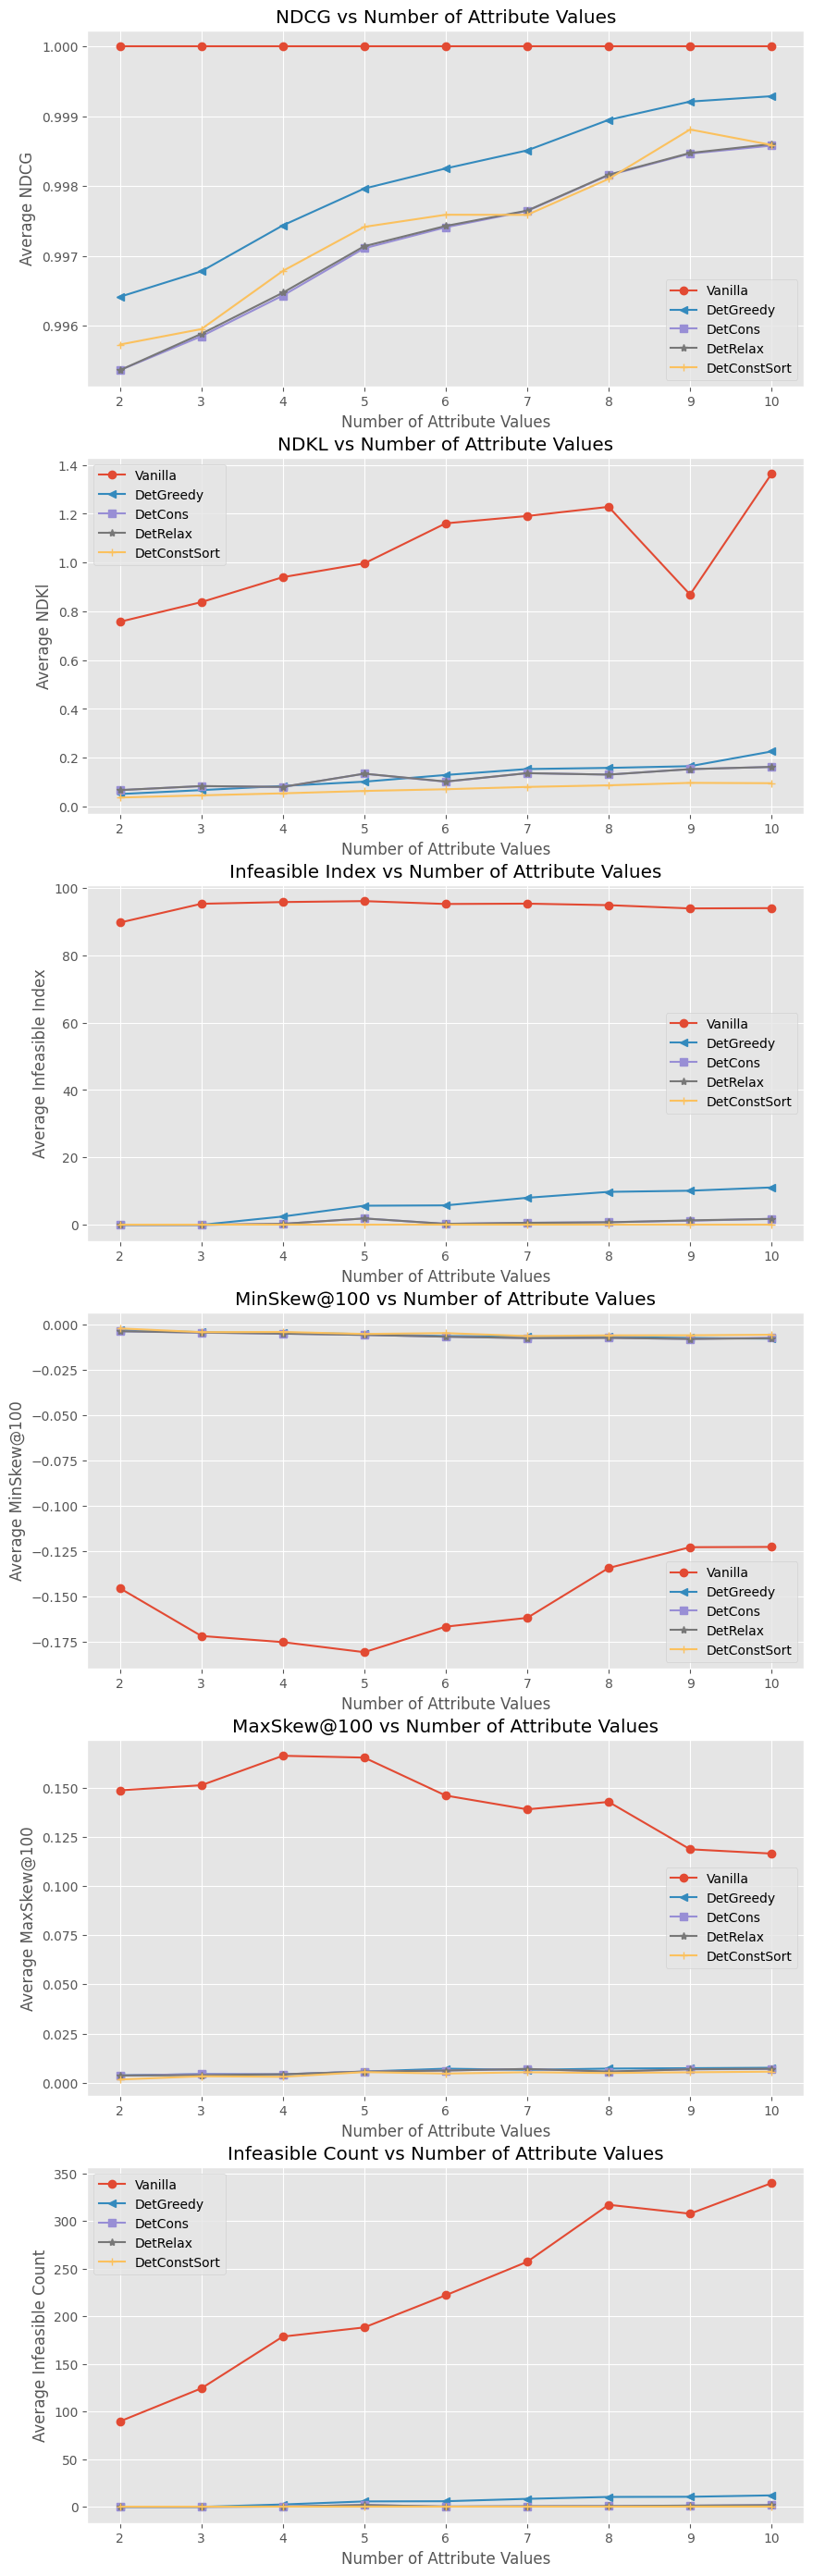

In [33]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1,figsize=(10,35))

pd.Series(ndcg_plot["vanilla"],index=np.arange(2,11)).plot(label='Vanilla',style='-o',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetGreedy"],index=np.arange(2,11)).plot(label='DetGreedy',style='-<',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetCons"],index=np.arange(2,11)).plot(label='DetCons',style='-s',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetRelax"],index=np.arange(2,11)).plot(label='DetRelax',style='-*',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetConstSort"],index=np.arange(2,11)).plot(label='DetConstSort',style='-+',kind='line',ax=ax1)
ax1.legend()
ax1.set_xlabel("Number of Attribute Values",)
ax1.set_ylabel("Average NDCG",)
ax1.set_title("NDCG vs Number of Attribute Values",)

pd.Series(ndkl_plot["vanilla"],index=np.arange(2,11)).plot(label='Vanilla',style='-o',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetGreedy"],index=np.arange(2,11)).plot(label='DetGreedy',style='-<',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetCons"],index=np.arange(2,11)).plot(label='DetCons',style='-s',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetRelax"],index=np.arange(2,11)).plot(label='DetRelax',style='-*',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetConstSort"],index=np.arange(2,11)).plot(label='DetConstSort',style='-+',kind='line',ax=ax2)
ax2.legend()
ax2.set_xlabel("Number of Attribute Values")
ax2.set_ylabel("Average NDKl")
ax2.set_title("NDKL vs Number of Attribute Values")

pd.Series(Inf_ind_plot["vanilla"],index=np.arange(2,11)).plot(label='Vanilla',style='-o',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetGreedy"],index=np.arange(2,11)).plot(label='DetGreedy',style='-<',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetCons"],index=np.arange(2,11)).plot(label='DetCons',style='-s',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetRelax"],index=np.arange(2,11)).plot(label='DetRelax',style='-*',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetConstSort"],index=np.arange(2,11)).plot(label='DetConstSort',style='-+',kind='line',ax=ax3)
ax3.legend()
ax3.set_xlabel("Number of Attribute Values")
ax3.set_ylabel("Average Infeasible Index")
ax3.set_title("Infeasible Index vs Number of Attribute Values")


pd.Series(Min_skew_plot["vanilla"],index=np.arange(2,11)).plot(label='Vanilla',style='-o',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetGreedy"],index=np.arange(2,11)).plot(label='DetGreedy',style='-<',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetCons"],index=np.arange(2,11)).plot(label='DetCons',style='-s',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetRelax"],index=np.arange(2,11)).plot(label='DetRelax',style='-*',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetConstSort"],index=np.arange(2,11)).plot(label='DetConstSort',style='-+',kind='line',ax=ax4)
ax4.legend()
ax4.set_xlabel("Number of Attribute Values")
ax4.set_ylabel("Average MinSkew@100")
ax4.set_title("MinSkew@100 vs Number of Attribute Values")

pd.Series(Max_skew_plot["vanilla"],index=np.arange(2,11)).plot(label='Vanilla',style='-o',kind='line',ax=ax5)
pd.Series(Max_skew_plot["DetGreedy"],index=np.arange(2,11)).plot(label='DetGreedy',style='-<',kind='line',ax=ax5)
pd.Series(Max_skew_plot["DetCons"],index=np.arange(2,11)).plot(label='DetCons',style='-s',kind='line',ax=ax5)
pd.Series(Max_skew_plot["DetRelax"],index=np.arange(2,11)).plot(label='DetRelax',style='-*',kind='line',ax=ax5)
pd.Series(Max_skew_plot["DetConstSort"],index=np.arange(2,11)).plot(label='DetConstSort',style='-+',kind='line',ax=ax5)
ax5.legend()
ax5.set_xlabel("Number of Attribute Values")
ax5.set_ylabel("Average MaxSkew@100")
ax5.set_title("MaxSkew@100 vs Number of Attribute Values")

pd.Series(Inf_count_plot["vanilla"],index=np.arange(2,11)).plot(label='Vanilla',style='-o',kind='line',ax=ax6)
pd.Series(Inf_count_plot["DetGreedy"],index=np.arange(2,11)).plot(label='DetGreedy',style='-<',kind='line',ax=ax6)
pd.Series(Inf_count_plot["DetCons"],index=np.arange(2,11)).plot(label='DetCons',style='-s',kind='line',ax=ax6)
pd.Series(Inf_count_plot["DetRelax"],index=np.arange(2,11)).plot(label='DetRelax',style='-*',kind='line',ax=ax6)
pd.Series(Inf_count_plot["DetConstSort"],index=np.arange(2,11)).plot(label='DetConstSort',style='-+',kind='line',ax=ax6)
ax6.legend()
ax6.set_xlabel("Number of Attribute Values")
ax6.set_ylabel("Average Infeasible Count")
ax6.set_title("Infeasible Count vs Number of Attribute Values")

plt.show()

### Boxplots

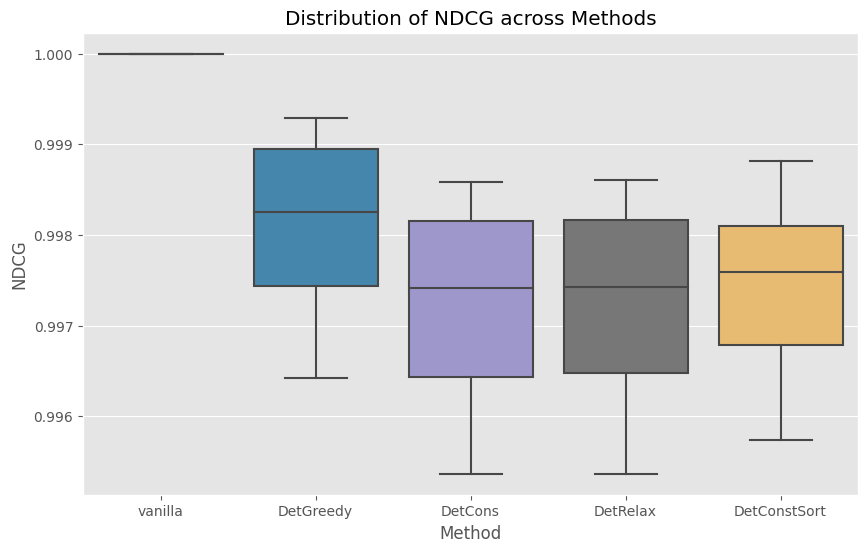

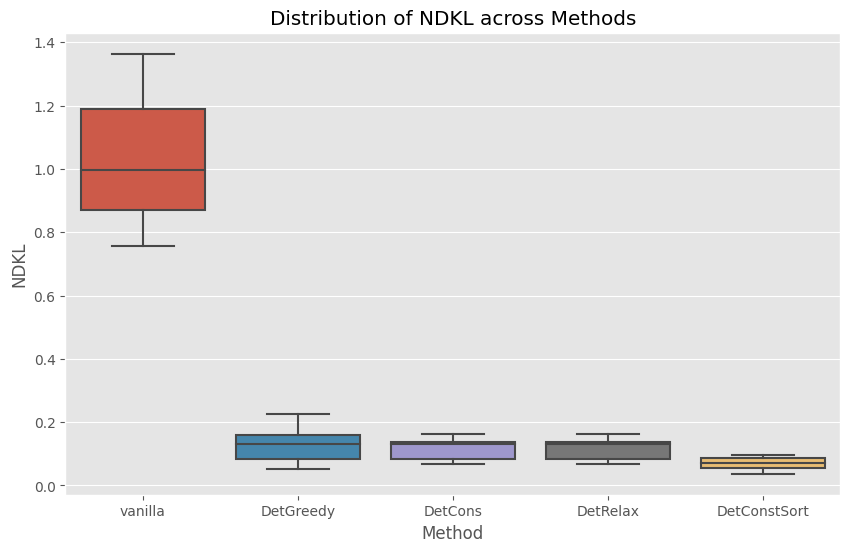

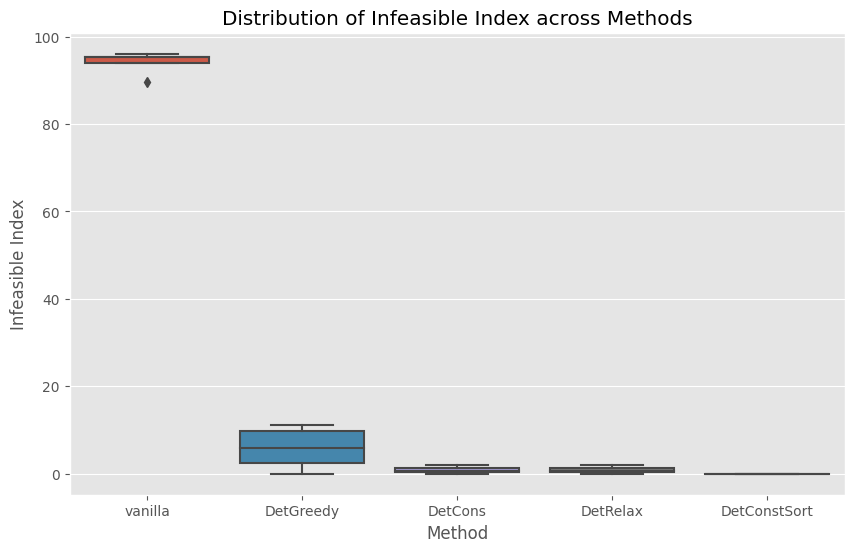

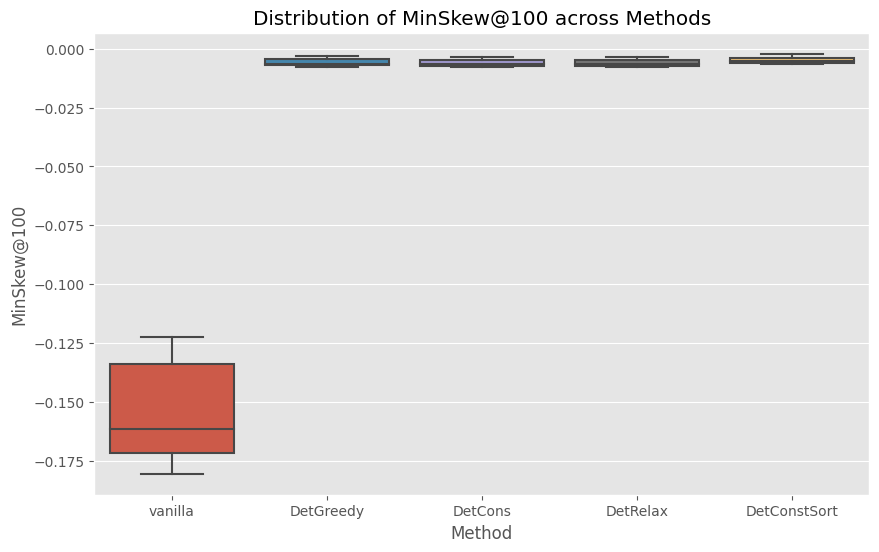

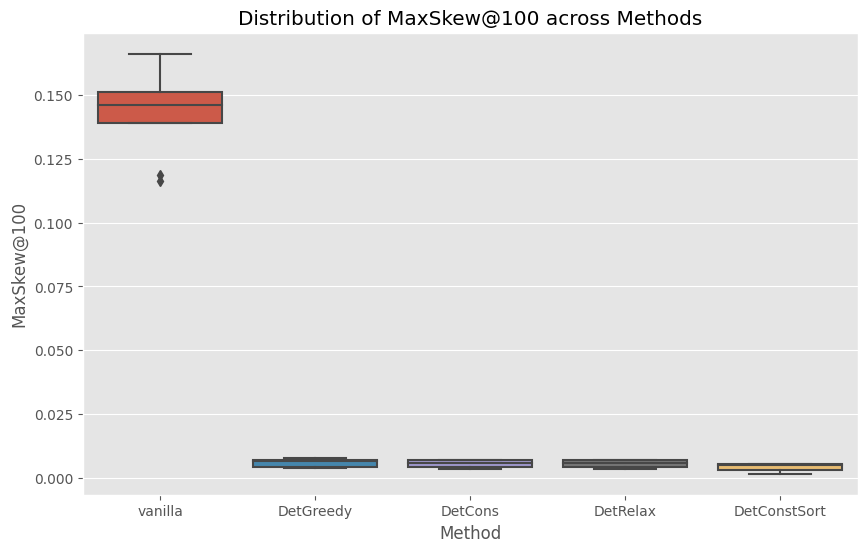

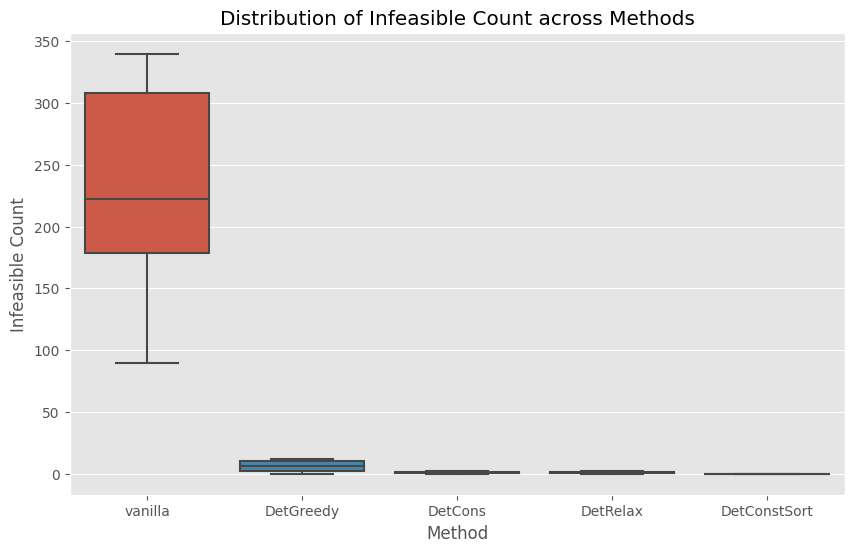

In [39]:
metrics_list = [
    ("NDCG", ndcg_plot),
    ("NDKL", ndkl_plot),
    ("Infeasible Index", Inf_ind_plot),
    ("MinSkew@100", Min_skew_plot),
    ("MaxSkew@100", Max_skew_plot),
    ("Infeasible Count", Inf_count_plot),
]


for metric_name, metric in metrics_list:
    plt.figure(figsize=(10, 6))
    metric_df = pd.DataFrame(metric)
    sns.boxplot(data=metric_df)
    plt.xlabel("Method")
    plt.ylabel(metric_name)
    plt.title(f"Distribution of {metric_name} across Methods")
    plt.show()

### Mapa de correlação

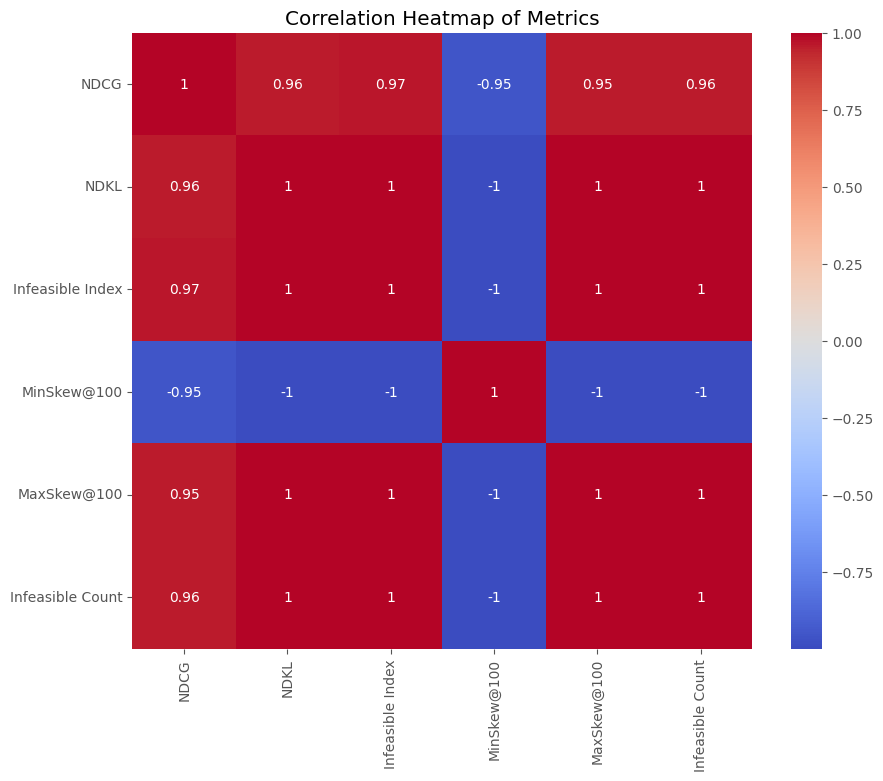

In [45]:
metrics = ['vanilla', 'DetGreedy', 'DetCons', 'DetRelax', 'DetConstSort']

data = {
    'NDCG': pd.DataFrame(ndcg_plot).mean(),
    'NDKL': pd.DataFrame(ndkl_plot).mean(),
    'Infeasible Index': pd.DataFrame(Inf_ind_plot).mean(),
    'MinSkew@100': pd.DataFrame(Min_skew_plot).mean(),
    'MaxSkew@100': pd.DataFrame(Max_skew_plot).mean(),
    'Infeasible Count': pd.DataFrame(Inf_count_plot).mean()
}

df = pd.DataFrame(data, index=metrics)

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Metrics")
plt.show()
